In [56]:
import numpy as np
import pandas as pd
import requests
import json

import matplotlib.pyplot as mp
import pandas as pd
import seaborn as sns

from scipy import stats as st

from google.colab import drive

drive.mount('/content/drive/')

path = "/content/drive/MyDrive/capstone/" # replace with your path

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [57]:
import requests
import json


class MakeApiCall:

    def get_data(self, api):
        response = requests.get(f"{api}")
        if response.status_code == 200:
            print("sucessfully fetched the data")
            self.formatted_print(response.json())
        else:
            print(
                f"Hello person, there's a {response.status_code} error with your request")

    def get_user_data(self, api, parameters):
        response = requests.get(f"{api}", headers=parameters)
        if response.status_code == 200:
            print("sucessfully fetched the data with parameters provided")
            self.formatted_print(response.json())
        else:
            print(
                f"Hello person, there's a {response.status_code} error with your request")

    def formatted_print(self, obj):
        text = json.dumps(obj, sort_keys=True, indent=4)
        print(text)

    def __init__(self, api):
         self.get_data(api)

        #parameters = {
            #'Authorization': 'access_token myToken'
        #}
        #self.get_user_data(api, parameters)


Separate SF into tiles w/ lat and long look ups

In [58]:
# SF is about ~15 km x 15 km
# The paper used 2 km x 2 km tiles
# Let's use 100 m x 100 m tile 

import geopy.distance
import math

#longest vertical distance
coords_1 = (37.811262, -122.477010)
coords_2 = (37.708251, -122.477010)

vertical_dist = geopy.distance.geodesic(coords_1, coords_2).m
v_count = math.ceil(vertical_dist / 100)

#longest horizontal distance 
coords_1 = (37.778946, -122.514446)
coords_2 = (37.778946, -122.357110)

horizontal_dist = geopy.distance.geodesic(coords_1, coords_2).m
h_count = math.ceil(horizontal_dist / 100)

In [59]:
# https://code.activestate.com/recipes/577713-midpoint-of-two-gps-points/ 

import math

def midpoint(x1, y1, x2, y2):
#Input values as degrees

#Convert to radians
    lat1 = math.radians(x1)
    lon1 = math.radians(x2)
    lat2 = math.radians(y1)
    lon2 = math.radians(y2)


    bx = math.cos(lat2) * math.cos(lon2 - lon1)
    by = math.cos(lat2) * math.sin(lon2 - lon1)
    lat3 = math.atan2(math.sin(lat1) + math.sin(lat2), \
           math.sqrt((math.cos(lat1) + bx) * (math.cos(lat1) \
           + bx) + by**2))
    lon3 = lon1 + math.atan2(by, math.cos(lat1) + bx)

    return [round(math.degrees(lat3), 6), round(math.degrees(lon3), 6)]

In [60]:
# If midpoint of tile is in the ocean, exclude
# https://gis.stackexchange.com/questions/235133/checking-if-a-geocoordinate-point-is-land-or-ocean

#from mpl_toolkits.basemap import Basemap
#bm = Basemap()   # default: projection='cyl'
#print (bm.is_land(99.675, 13.104))  #True
#print (bm.is_land(100.539, 13.104))  #False

In [61]:
# Make a dataframe with:
# Tile #
# Upper left coordinate
# Upper right
# Lower left
# lower right 
# midpoint 

long_interval = np.linspace(-122.357110, -122.514446, h_count)

lat_interval = np.linspace(37.708251, 37.811262, v_count)

tiles = pd.DataFrame(columns = ['Tile_ID', 'Lat1', 'Lat2', 'Long1', 'Long2', 'Mid'])

count1 = 0
for lai in range(len(lat_interval) - 1): 
    lat1 = lat_interval[lai]
    lat2 = lat_interval[lai + 1]
    for loi in range(len(long_interval) - 1):
        long1 = long_interval[loi]
        long2 = long_interval[loi + 1]
        mid = midpoint(lat1, long1, lat2, long2)
        #if bm.is_land(mid[0], mid[1]) == True:
           # continue
        t = pd.DataFrame([[count1, lat1, lat2, long1, long2, mid]], columns = ['Tile_ID', 'Lat1', 'Lat2', 'Long1', 'Long2', 'Mid'])
        tiles = pd.concat([tiles, t], ignore_index = True)
        count1 += 1


In [62]:
tiles.head(5)

,Tile_ID,Lat1,Lat2,Long1,Long2,Mid
0,0,37.708251,37.709155,-122.35711,-122.358250,"[-10.111211, 45.733374]"
1,1,37.708251,37.709155,-122.35825,-122.359390,"[-10.110617, 45.733069]"
2,2,37.708251,37.709155,-122.35939,-122.360530,"[-10.110023, 45.732764]"
3,3,37.708251,37.709155,-122.36053,-122.361670,"[-10.10943, 45.732459]"
4,4,37.708251,37.709155,-122.36167,-122.362811,"[-10.108836, 45.732155]"


Split street characterstics into tiles

Split historical and future collision data into tiles

In [63]:


collisions = pd.read_csv(r'/content/drive/MyDrive/capstone/transbase_collisions_02112023.csv')
collisions.head(5)

#collisions.columns

# dataset is from 2017 - September 30 2022
# Historical Group: Oct 1 2018 - September 30 2020
# Future Group: Oct 1 2020 - September 30 2022

collisions['Historical'] = np.where((collisions['collision_date'] >= 20181001) & (collisions['collision_date'] <= 20200930),1,0)

collisions['Future'] = np.where((collisions['collision_date'] >= 20201001) & (collisions['collision_date'] <= 20220930),1,0)

collisions.tail(5)

,type,geometry,case_id_pkey,collision_severity,accident_year,collision_date,collision_time,distance,direction,pcf_viol_category,...,bndy_type,party_at_fault,party1_type,party1_dir_of_travel,party1_move_pre_acc,party2_type,party2_dir_of_travel,party2_move_pre_acc,Historical,Future
14861,Feature,[object Object],220693629,Injury (Complaint of Pain),2022,20220809,1320.0,0,Not Stated,Unsafe speed for prevailing conditions,...,Geographic Boundary,1.0,Driver,East,Not Stated,Driver,East,Stopped,0,1
14862,Feature,[object Object],220701028,Injury (Severe),2022,20220830,1410.0,0,Not Stated,Unsafe turn or lane change prohibited,...,Geographic Boundary,1.0,Driver,Not Stated,Making Right Turn,Bicyclist,West,Not Stated,0,1
14863,Feature,[object Object],220832383,Injury (Complaint of Pain),2022,20220324,1650.0,0,Not Stated,Entering highway from alley or driveway,...,Geographic Boundary,1.0,Driver,North,Proceeding Straight,Driver,North,Entering Traffic,0,1
14864,Feature,[object Object],222006691,Injury (Complaint of Pain),2022,20220130,1930.0,0,Not Stated,Unsafe speed for prevailing conditions,...,Geographic Boundary,1.0,Driver,South,Proceeding Straight,Driver,East,Proceeding Straight,0,1
14865,Feature,[object Object],9335-2020-00557,Fatal,2020,20200317,2015.0,0,Not Stated,Red signal - driver or bicyclist responsibilities,...,Geographic Boundary,1.0,Driver,Not Stated,Proceeding Straight,Driver,Not Stated,Proceeding Straight,1,0


In [64]:
# adding historical and future collisions to data frame

# 'Tile_ID', 'Lat1', 'Lat2', 'Long1', 'Long2', 'Mid'
collisions = collisions[(collisions['Future'] == 1) | (collisions['Historical'] == 1)]
collisions_f = collisions[collisions['Future'] == 1]
collisions_h = collisions[collisions['Historical'] == 1]
# for every tile, sum the future and historical collisions 
# the collision should take place within the tile 
fut = []
his = []
for i in range(len(tiles)):
    ti = tiles.iloc[i]
    lat1 = ti['Lat1']
    lat2 = ti['Lat2']
    long1 = ti['Long1']
    long2 = ti['Long2']
    f = len(collisions_f[(collisions_f['latitude'] < lat2) & (collisions_f['latitude'] > lat1) & (collisions_f['longitude'] > long2) & (collisions_f['longitude'] < long1)])
    h = len(collisions_h[(collisions_h['latitude'] < lat2) & (collisions_h['latitude'] > lat1) & (collisions_h['longitude'] > long2) & (collisions_h['longitude'] < long1)])
    fut = np.append(fut,f)
    his = np.append(his,h)

In [65]:
tiles['Future'] = fut
tiles['Historical'] = his

In [66]:
tiles.head(5)

,Tile_ID,Lat1,Lat2,Long1,Long2,Mid,Future,Historical
0,0,37.708251,37.709155,-122.35711,-122.358250,"[-10.111211, 45.733374]",0.0,0.0
1,1,37.708251,37.709155,-122.35825,-122.359390,"[-10.110617, 45.733069]",0.0,0.0
2,2,37.708251,37.709155,-122.35939,-122.360530,"[-10.110023, 45.732764]",0.0,0.0
3,3,37.708251,37.709155,-122.36053,-122.361670,"[-10.10943, 45.732459]",0.0,0.0
4,4,37.708251,37.709155,-122.36167,-122.362811,"[-10.108836, 45.732155]",0.0,0.0


In [67]:
tiles.tail(5)

,Tile_ID,Lat1,Lat2,Long1,Long2,Mid,Future,Historical
15727,15727,37.810358,37.811262,-122.508745,-122.509886,"[-9.979097, 45.760321]",0.0,0.0
15728,15728,37.810358,37.811262,-122.509886,-122.511026,"[-9.978504, 45.760012]",0.0,0.0
15729,15729,37.810358,37.811262,-122.511026,-122.512166,"[-9.977911, 45.759703]",0.0,0.0
15730,15730,37.810358,37.811262,-122.512166,-122.513306,"[-9.977318, 45.759394]",0.0,0.0
15731,15731,37.810358,37.811262,-122.513306,-122.514446,"[-9.976724, 45.759085]",0.0,0.0


Scrape data and create model that takes inputs of satellite images or OSM files

EDA

In [78]:
tiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15732 entries, 0 to 15731
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Tile_ID     15732 non-null  object 
 1   Lat1        15732 non-null  float64
 2   Lat2        15732 non-null  float64
 3   Long1       15732 non-null  float64
 4   Long2       15732 non-null  float64
 5   Mid         15732 non-null  object 
 6   Future      15732 non-null  float64
 7   Historical  15732 non-null  float64
dtypes: float64(6), object(2)
memory usage: 983.4+ KB


In [69]:
columns_all = ["Tile_ID", "Lat1", "Lat2", "Long1", "Long2", "Mid", "Future", "Historical"]

#columns_numeric = ["Lat1", "Lat2", "Long1", "Long2", "Future", "Historical"]

                    Lat1          Lat2         Long1         Long2    Future  \
Lat1        1.000000e+00  1.000000e+00  1.219339e-12  1.079946e-12  0.044614   
Lat2        1.000000e+00  1.000000e+00  1.216505e-12  1.077094e-12  0.044614   
Long1       1.219339e-12  1.216505e-12  1.000000e+00  1.000000e+00  0.056719   
Long2       1.079946e-12  1.077094e-12  1.000000e+00  1.000000e+00  0.056719   
Future      4.461376e-02  4.461376e-02  5.671917e-02  5.671917e-02  1.000000   
Historical  4.983614e-02  4.983614e-02  5.792078e-02  5.792078e-02  0.751067   

            Historical  
Lat1          0.049836  
Lat2          0.049836  
Long1         0.057921  
Long2         0.057921  
Future        0.751067  
Historical    1.000000  


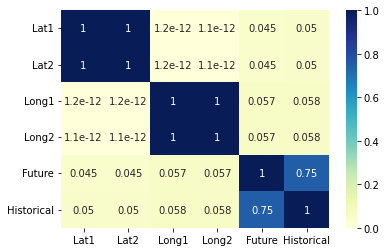

In [70]:
# prints data that will be plotted
# columns shown here are selected by corr() since
# they are ideal for the plot
print(tiles.corr())
  
# plotting correlation heatmap
dataplot = sns.heatmap(tiles.corr(), cmap="YlGnBu", annot=True)

<ipython-input-71-8ee179e018ba>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


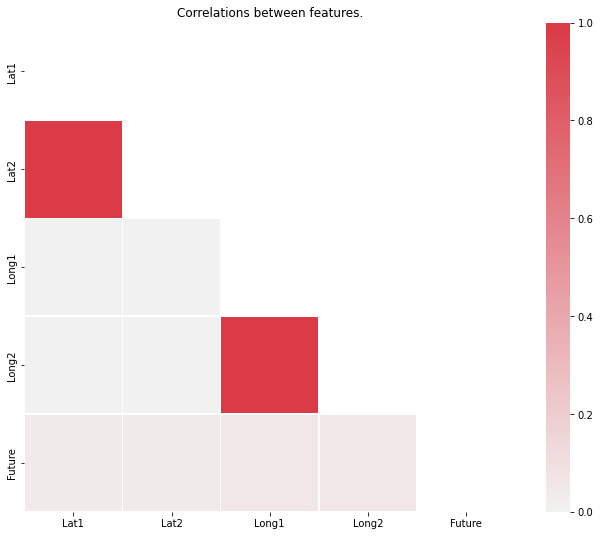

In [71]:
corr = tiles[columns_all[:-1]].corr()
fig, ax = mp.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
mp.title("Correlations between features.")
mp.show()

Based on the correlation matrix above, the accident_year and collision_date variables have strong correlation with the target variable, Future.

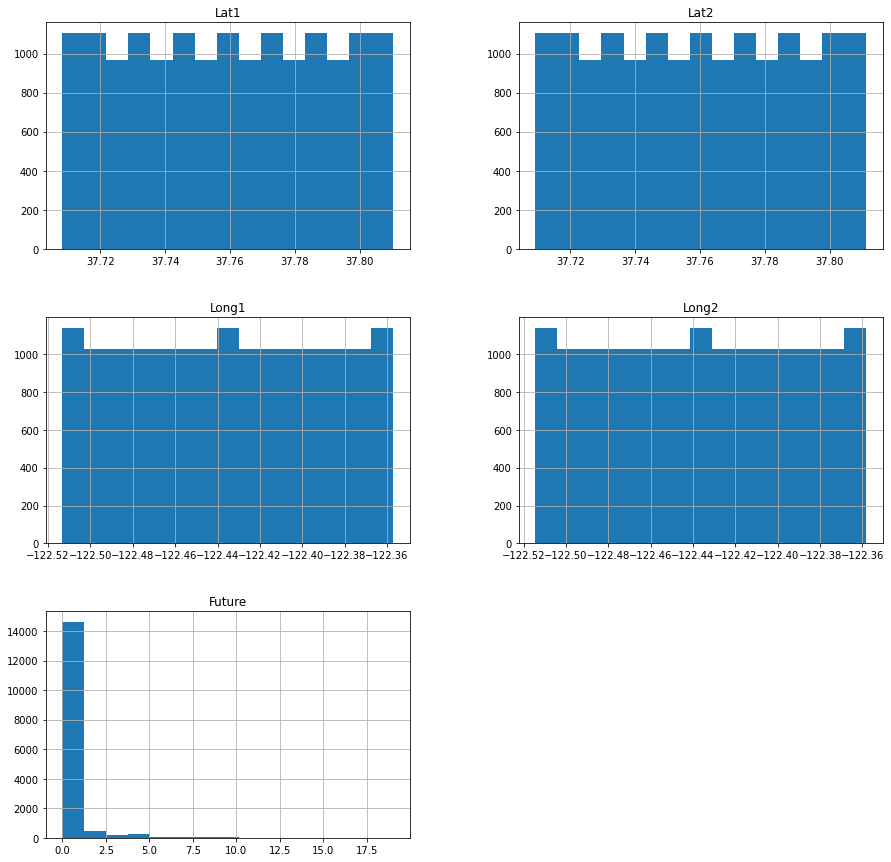

In [72]:
tiles[columns_all[:-1]].hist(figsize=(15,15), bins=15)
mp.show()

IndexError: ignored

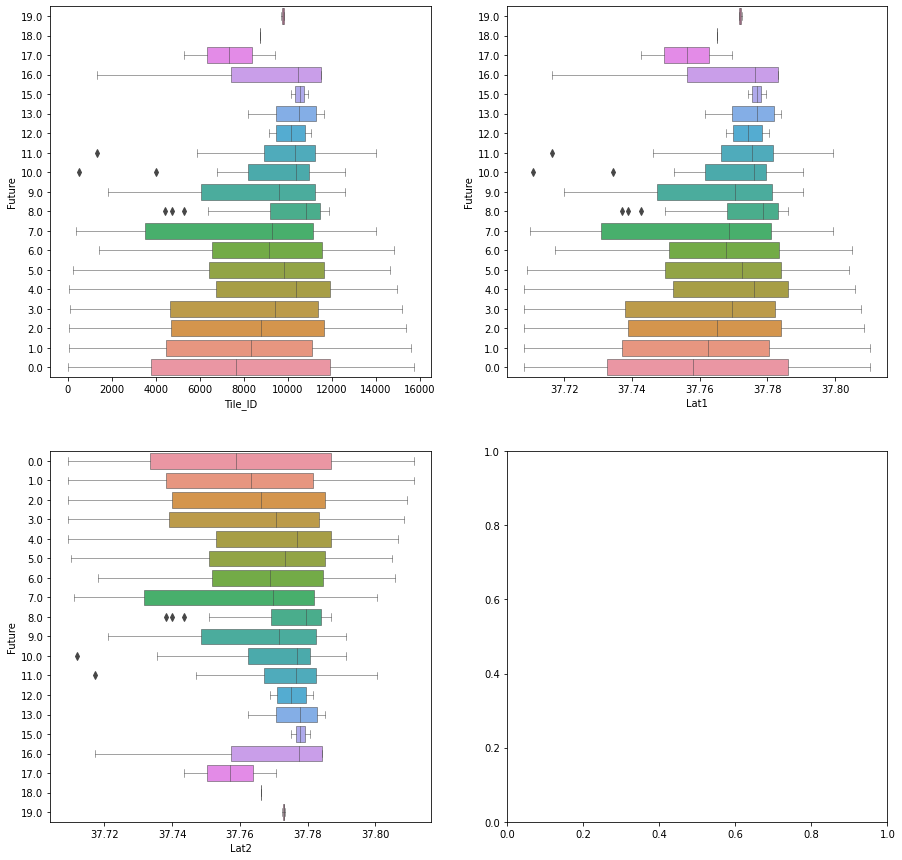

In [89]:
fig, ax_grid = plt.subplots(2, 2, figsize=(15,15))
y = tiles['Future']
for idx, feature in enumerate(columns_all[:4]):
    x = tiles[feature]
    sns.boxplot(x=x, y=y, ax=ax_grid[idx//2][idx%2], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
fig.suptitle("Individual Features vs. Outcome (Future)", fontsize=15, y=0.9)
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f29259ca6d0>,
      dtype=object)

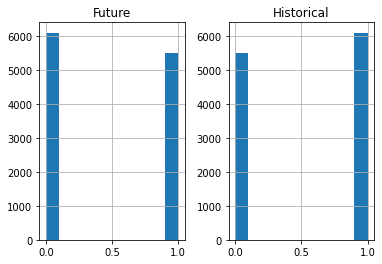

In [73]:
#how many tiles had the same historical and future number of collisions, how many went up, and how many went down

collisions = collisions[(collisions['Future'] == 1) | (collisions['Historical'] == 1)]
collisions_f = collisions[collisions['Future'] == 1]
collisions_h = collisions[collisions['Historical'] == 1]

collisions_count = collisions[['Future', 'Historical']]
#collisions_count.head()
collisions_count.hist()

Split into training and test

In [74]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(tiles[['Historical', 'Lat1','Lat2']], 
                                   tiles['Future'],
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)

Train model

In [75]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

# x: lat, long, historical
# y: future 

def create_linear_model():

    input = tf.keras.layers.Input(shape=(3,))
    
    #input_t = tf.data.Dataset.from_tensor_slices(input.to_dict(orient="list"))

    normalized = layers.Normalization(input_shape=[3,], axis=None)(input)

   #x = normalizer(input_t)

    outputs = layers.Dense(1, activation = 'relu')(normalized)

    linear_model = tf.keras.models.Model(inputs=input, outputs=outputs, name="linear_model")

    linear_model.summary()

    linear_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_absolute_error',
        metrics = [tf.keras.metrics.Accuracy()])
    
    return linear_model

linear_model = create_linear_model()

history = linear_model.fit(
    np.asarray(x_train).astype('float32'),
    y_train,
    epochs=10,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Model: "linear_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 normalization (Normalizatio  (None, 3)                3         
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 7
Trainable params: 4
Non-trainable params: 3
_________________________________________________________________
Epoch 1/10
315/315 [==============================] - 3s 6ms/step - loss: 2.4735 - accuracy: 0.4661 - val_loss: 0.3572 - val_accuracy: 0.8729
Epoch 2/10
315/315 [==============================] - 1s 4ms/step - loss: 0.3466 - accuracy: 0.8583 - val_loss: 0.35

In [76]:
import matplotlib
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error/Accuracy')
    plt.legend()
    plt.grid(True)

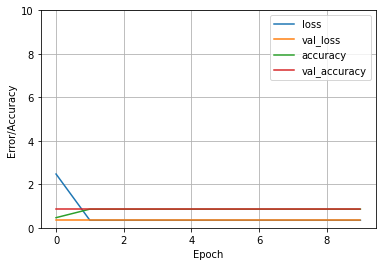

In [77]:
plot_loss(history)

Test model

Model actual future collisions

Create dashboard featuring future hotspots